Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

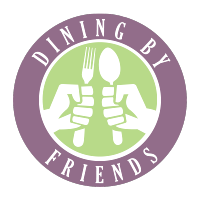

# Dining By Friends in Amazon Neptune

> **Foreword:** While writing Graph Databases in Action, one of our driving principals was to build a framework that leveraged open source frameworks and languages as much as possible.  Amazon Neptune's support for both Apache TinkerPop Gremlin and openCypher makes it a great choice to demonstrate the transferability of the framework of our book across query languages - *Dave Bechberger, co-author of Graph Databases in Action*

## Background

*[Graph Databases in Action](https://www.manning.com/books/graph-databases-in-action?a_aid=bechberger)* by Manning Publications is a book that provides readers with a framework for how to approach building applications using common graph development patterns. To teach this framework, the book uses these patterns to build a fictitious application, DiningByFriends, that uses friends and ratings to provide personalized restaurant recommendations. To accomplish this, DiningByFriends follows the development of three common graph use cases, a social network of users, a recommendation engine, and a personalization engine. Each of these use cases builds on top of one another in such a way as to leverage existing skills to answer ever more complex questions.

In the following notebook, we demonstrate how to use Amazon Neptune to build the queries for the DiningByFriends app.  This notebook will not focus on the processing and framework for constructing the queries, which is described in detail in the book. Instead, this notebook will highlight how to accomplish these use cases within Amazon Neptune.  

One of the unique aspects of Amazon Neptune is that it allows you to run both Apache TinkerPop Gremlin and openCypher queries on top of the same data. In the notebook below, we have presented a selection of the most important queries from the book in both languages. This allows you to look at the differences between the two query languages. In each example, we will first show the Gremlin traversal from the book and discuss any modifications required. We will then show the comparable openCypher query and discuss any highlight and differences you may want to be aware of between the two languages. You are welcome to run whichever you prefer, or both, to see the results.

## Getting Started

To get started with this notebook, we have added the data used in the book to the %seed command, so you can load your cluster using the command below.
*Note* - This notebook assumes the cluster was empty before this command being run.


In [ ]:
%seed --model Property_Graph --dataset dining_by_friends --run

Now that we have our data loaded let's take a look at how DiningByFriends works when using Amazon Neptune.

# Social Network

In Chapters 3 and 4 of the book, we went through the steps required to build a simple graph-based application by creating a social network for DiningByFriends. Social networks are often thought of as some of the most canonical use cases, where people are represented as the nodes in the graph and the connections between the nodes are represented by edges.

Let's look at our entire social network data for DiningByFriends. Typically, this is not recommended as networks with more than hundreds of results tend to be unintelligible. This social network graph is a realistic yet much smaller representation than what you would normally be working against.


In [ ]:
%%gremlin -p v,oute,inv -d first_name

g.V().hasLabel('person').outE('friends').inV().path().by(elementMap())

In [ ]:
%%opencypher -d first_name

MATCH p=(:person)-[:friends]->(:person) 
RETURN p


## Get Friends - Who are Ted's Friends?

In *Graph Databases in Action*, a lot of time was spent learning an underlying framework for thinking about graph problems and how to approach solving them. In the book, we went through the steps to develop a Gremlin traversal to answer "Who are Ted's friends?", shown below. When working with Neptune, we can copy that traversal to get that answer.

In [ ]:
%%gremlin

g.V().has('person', 'first_name', 'Ted').
out('friends').valueMap('first_name')

In [ ]:
%%opencypher 

MATCH (:person {first_name:'Ted'})-[:friends]->(p) 
RETURN p.first_name

While we are not going to go into much detail about the differences between Gremlin and openCypher, one important difference to notice is that in Gremlin returns the `first_name` as a List while openCypher returns it as a single value.  

## Get Friends of Friends - Who are the Friends of Friends of Ted?

As with the previous query, we can copy and paste the query developed in the book for use with Amazon Neptune.  

In [ ]:
%%gremlin
g.V().has('person', 'first_name', 'Ted').
 repeat(
     out('friends')
 ).times(2).
 values('first_name')

In [ ]:
%%opencypher 

MATCH (:person {first_name:'Ted'})-[:friends]->()-[:friends]->(p:person) 
RETURN DISTINCT p.first_name

In this query, you may notice that both the Gremlin and openCypher return a single value.  For Gremlin, this is due to the use of the values() step instead of the valueMap() step.  However, you may also notice that the openCypher version still remains a key/value pair while the Gremlin version is just a string.

## Get the Path between Two Friends - How are Ted and Denise connected?

One of the most powerful things in graph databases is the ability to perform recursive traversals over your data to find unknown connections.  This functionality is available in both Gremlin, through the use of repeat(), and in openCypher, through the use of variable length paths `[:1..4]`.  In the book, we went through why constructing paths is important and the sorts of problems you may potentially encounter when using them.  

While we could copy and paste the Gremlin traversal from the book, the query below has a few changes to it to make it display better.  Specifically:

* `both("friends").simplePath()`  changed to `bothE("friends").otherV().simplePath()` to include the edge direction in the visualization of the results
* `by(elementMap())` was added to the `path()` to return the properties for display

In [ ]:
%%gremlin -d first_name

g.V().has("person", "first_name", 'Ted').
                until(has("person", "first_name", 'Denise')).
                repeat(
                        bothE("friends").otherV().simplePath()
                ).path().by(elementMap())

In [ ]:
%%opencypher -d first_name
MATCH p=(src:person {first_name:'Ted'})-[:friends*1..]-(dst:person {first_name:'Denise'})
RETURN p

When looking at the openCypher query above, it appears very intuitive, yet there is a potential complexity hiding regarding cycles.  In Gremlin, we add a `simplePath()` step to filter out any vertices we have already visited in a recursive traversal which allows you to avoid cycles in a graph.  openCypher takes a different approach and only prevents you from traversing the same edge multiple times in the same path.  This means that if you had two edges between vertices (e.g. two `friends` edges between `Dave` and `Kelly`), then each one would be treated as a unique path which can lead to repeatedly cycling through the same set of vertices.  In general, the best way to avoid this is to add a maximum number to the variable length path expression (e.g. `[:friends*1..4]`).

# Recommendation

In Chapter 8, we used known walks in graphs to build out a recommendation engine for DiningByFriends. A walk is a specific type of path in a graph which consists of a set of vertices and incident edges, and a known walk is a path where you specify certain vertices and incident edges. Recommendation engines are a common graph use case, and known walks are one way in which we can use the connections within our data to provide answers to complex real-world questions.

Let's take a look at the restaurant and review data within our DiningByFriends data.

In [ ]:
%%gremlin -d name

g.V().hasLabel('restaurant').bothE().otherV().path().by(elementMap())

In [ ]:
%%opencypher -d name
MATCH p=(:restaurant)-[]-()
RETURN p

## What are the newest reviews for a restaurant?

One of the simplest patterns of known walks in a graph are to traverse from a vertex to an incident edge, then to the adjacent vertex. To see this function in Amazon Neptune, copy and paste the Gremlin traversal we developed in the book.

In [ ]:
%%gremlin

g.V().has("restaurant", "restaurant_id", 8).
                in("about").
                order().
                    by("created_date").
                limit(3).
                elementMap("rating", "body", "created_date")

In [ ]:
%%opencypher 
MATCH (:restaurant {restaurant_id:8})<-[:about]-(r:review)
RETURN r.rating, r.body, r.created_date
ORDER BY r.created_date DESC
LIMIT 3

Comparing the openCypher query to the equivalent Gremlin traversal, we see that openCypher's ASCII art-based pattern-matching syntax (e.g. `()-[]->()`) excels at making the query easy to read and understand when dealing with these sorts of known walks in queries.

## What restaurants does a person rate highly?

Below is an example of a more complicated known walk that uses grouping and projecting of results to build a more complex result set.

In [ ]:
%%gremlin

g.V().has("person", "person_id", 8).
                out("lives").
                in("within").
                where(inE("about")).
                group().
                    by(identity()).
                    by(in("about").values("rating").mean()).
                unfold().
                order().
                    by(values, Order.desc).
                limit(10).
                project("name", "address", "rating_avg").
                    by(select(keys).values("name")).
                    by(select(keys).values("address")).
                    by(select(values))

In [ ]:
%%opencypher 

MATCH (:person {person_id:8})-[:lives]->(:city)<-[:within]-(r:restaurant)<-[:about]-(v:review)
WITH r, avg(v.rating) AS rating_average
RETURN r.name AS name, 
r.address AS address, rating_average
ORDER BY rating_average DESC 
LIMIT 10

Looking at the two different queries, one difference you notice is that the openCypher version of the query does not explicitly require grouping the results together to get the average rating.  In openCypher, grouping is implicitly performed when returning a key and an associated aggregate, as is done within this portion of the query `WITH r, avg(v.rating) AS rating_average`.  In our Gremlin traversal, we must explicitly perform this grouping to get the average rating for a specific restaurant.

## What restaurants near the person with a specific cuisine is the highest rated?

The final example of a known walk from the book is an example of a known walk that traverses several branches to filter and answer the question. This was another example query where we could copy and paste our Gremlin traversal directly from the book.

In [ ]:
%%gremlin

g.V().has('person','person_id',1).
 out('lives').
 in('within').
 where(out('serves').has('name', within('diner', 'bar'))).
 where(inE('about')).
 group().
     by(identity()).
     by(__.in('about').values('rating').mean()).
 unfold().
 order().
     by(values, desc).
 limit(1).
 project('name', 'address', 'rating_average', 'cuisine').
     by(select(keys).values('name')).
     by(select(keys).values('address')).
     by(select(values)).
     by(select(keys).out('serves').values('name'))

In [ ]:
%%opencypher

MATCH (p:person)-[:lives]->(:city)<-[:within]-(r:restaurant)-[:serves]->(c:cuisine) 
WHERE p.person_id = 1 AND c.name IN ['diner', 'bar'] 
WITH r
MATCH (r)<-[:about]-(v:review) 
WITH r, avg(v.rating) AS rating_average 
RETURN r.name AS name, 
    r.address AS address, rating_average
ORDER BY rating_average DESC 
LIMIT 1

One of the differences you will notice between the Gremlin and openCypher traversals is that in Gremlin we traverse our graph, filter on branches using `where()`, and then group the results at the end.  With openCypher's pattern matching syntax, we have to approach this slightly differently.  openCypher does not provide the same branching capabilities that Gremlin has, so we must first match our base pattern (Finding restaurants that serve a cuisine in the person's city), filter on this pattern to find the types of cuisine we want, then do an additional match on those filtered results to get the review and calculate the average.

# Personalization

Personalization of restaurant recommendations is a type of [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) approach to recommendation engines that uses information about a user's likes/dislikes (in this case, we use your friends likes/dislikes) to provide recommendations.

## What restaurants do my friends recommend?

To answer this question, we must take a different approach from the one described in the book.  In the book, we leveraged sessions within Gremlin to pull a subgraph into the memory of Gremlin server for computing recommendations.  While this approach can provide some benefits, as discussed in the book, using sessions is not supported in Amazon Neptune. Luckily, this is not the only way to achieve this end goal; another way is create the subgraph and filter on the recommendations within the same traversal as we have done with the traversal below.

We recommend you also try this traversal with some different `person_id` values to see how the results are personalized for a specific user.

In [ ]:
%%gremlin

g.V().
  has('person', 'person_id', 8).
  both('friends').
  both('wrote').as('v').
  both('about').
  where(both('within').has('city', 'name', 'Houston')).
  group().by().by(select('v').values('rating').mean()).unfold().
  order().by(values, desc).limit(3).
  project("rating_average","name","address","restaurant_id").
                by(__.select(values)).
                by(__.select(keys).values("name")).
                by(__.select(keys).values("address")).
                by(__.select(keys).values("restaurant_id"))

In [ ]:
%%opencypher 

MATCH (p:person {person_id:8})-[:friends]-()-[:wrote]-(v)-[:about]-
(r:restaurant)-[:within]-(c:city {name:'Houston'}) 
RETURN avg(v.rating) as rating_average, r.name AS name, r.address AS address, r.restaurant_id AS restaurant_id
ORDER BY rating_average DESC
LIMIT 3

# Summary

As we can see throughout this notebook, both Apache TinkerPop Gremlin and openCypher are powerful graph query languages that have their strengths and weaknesses. The more important thing to understand is that no matter which language you choose, the framework and approach to working with graph data to build applications remains the same.  